# **Assignment 2: Machine Learning with Spark**
Students:
- Hugo Hernández López (100563523)
- Manuel Marín Moreno (100564929)



# **Introduction**
The main objective of the assignment is to evaluate whether feature selection techniques can improve the model's performance or even mantain it, using less variables.

We will test it using a Logistic Regression classifier. We will implement and compare four different approaches:

1.  **Baseline:** No feature selection.
2.  **FPR Strategy:** Selection based on the False Positive Rate.
3.  **FWE Strategy:** Selection based on the Family-Wise Error rate.
4.  **Percentile Strategy:** Selecting the top 25% of features.


In this Assignment, we will build pipelines using Spark, that directly handle the preprocessing, feature selection, and model training.

## **Set up**

Since we are running this notebook in Google Colab, we must first give Google Drive  access to the dataset.

In [1]:
import os
from google.colab import drive

drive.mount('/content/drive')

desired_folder_name = ['Big_Data_Intelligence','datasets bdi']
target_path = None

for filder in desired_folder_name:
  potential_mydrive_path = os.path.join('/content/drive/MyDrive', filder)
  if os.path.exists(potential_mydrive_path):
      target_path = potential_mydrive_path
      print(f"The folder '{desired_folder_name}' found in MyDrive.")
      break
if target_path:
    os.chdir(target_path)
    print(f"Working directory has been changed to: {os.getcwd()}")
else:
    print(f"Warning: Could not find and change to directory '{desired_folder_name}'.")

Mounted at /content/drive
The folder '['Big_Data_Intelligence', 'datasets bdi']' found in MyDrive.
Working directory has been changed to: /content/drive/MyDrive/datasets bdi


## **Dependencies**

In this section, we import the necessary libraries for the Assignment.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, UnivariateFeatureSelector
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pyspark.sql.functions as F

## **Initialization**
Here, we define the global constants for the project; such as the `csv` file name and the Seed.
We also initialize the **SparkSession**.

In [3]:
PICKLE_MODELING_FILE='bank_23.csv'
SEED=100563523

In [4]:
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .getOrCreate()
sc = spark.sparkContext

print(spark)
print(sc)

<SparkContext master=local[*] appName=Python Spark SQL basic example>


# **Load Dataset**

In this section, we transform the dataset into a Spark DataFrame. We utilize the `spark.read.csv` method.

In [5]:
ava_sd=spark.read.csv(path=PICKLE_MODELING_FILE,header=True,inferSchema=True)

#header = True allows us to intepret the first row as column names
#InferSchema = True allows Spark to detect the data types automatically

In [6]:
ava_sd.show()

+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|        job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
| 59|     admin.| married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
| 56|     admin.| married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
| 41| technician| married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
| 55|   services| married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|    yes|
| 54|     admin.| married| tertiary|     no|    184|     no|  

Before proceeding to preprocessing, it is essential to verify the structure and volume of our data. We examine the schema to confirm that variable types have been correctly inferred and check the total number of records to ensure the dataset has been loaded completely.

In [7]:
print(type(ava_sd))

print('SCHEMA:')
print(ava_sd.printSchema())
print('\nCOLUMNS:')
print(ava_sd.columns)
print('\nDTYPES:')
print(ava_sd.dtypes)

<class 'pyspark.sql.classic.dataframe.DataFrame'>
SCHEMA:
root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)

None

COLUMNS:
['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit']

DTYPES:
[('age', 'int'), ('job', 'string'), ('marital', 'string'), ('education', 'string

# **Pipelines Creation**

We distinguish between categorical and numerical features to apply the appropriate processing strategies. Categorical strings require indexing and encoding to be interpreted by the model, whereas numerical values are treated as continuous inputs and are passed directly to the vector assembler.

In [8]:
cat_cols = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome"]
num_cols = ["age", "balance", "day", "duration", "campaign", "pdays", "previous"]
label_col = "deposit"

To ensure code efficiency and scalability, we implement a loop to process the categorical variables. Instead of manually defining separate transformers for each attribute, which would be repetitive and prone to errors, this iterative approach applies the indexer and encoder uniformly to all categorical columns, automatically appending them to the pipeline stages.

Finally, we construct the `features` vector by combining these newly encoded variables with the numerical columns, ensuring all inputs are correctly consolidated for the model.

Let's analyze the categorical transformations in more detail:

First, the `StringIndexer` maps category strings to numerical indices based on frequency. The parameter `handleInvalid='keep'` assigns a special extra index to any null values or unseen categories, effectively handling imputation without discarding data.

Second, the `OneHotEncoder` converts these indices into binary vectors (dummy variables). This ensures the model treats categories as distinct entities without inferring a false numerical hierarchy. Finally, we dynamically add these new encoded features to our input list for the vector assembler.

In [9]:
stages = []

for col in cat_cols:
    indexer = StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid="keep")
    encoder = OneHotEncoder(inputCols=[f"{col}_idx"], outputCols=[f"{col}_ohe"], handleInvalid="keep")
    stages += [indexer, encoder]

Finally, we process the target variable separately by indexing it into a numerical label.

To construct the single feature vector required by the algorithm, we aggregate all input variables using list comprehension. This approach reconstructs the names of the encoded categorical features and combines them with the numerical columns, effectively feeding the `VectorAssembler` with the complete set of predictors.

In [10]:
label_indexer = StringIndexer(inputCol=label_col, outputCol="label")
stages.append(label_indexer)

assembler_inputs = [f"{col}_ohe" for col in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
stages.append(assembler)


We partition the preprocessed dataset into Train (80%) and Test (20%) to assess the model's generalization performance on unseen data.

In [11]:
train_df, val_df = ava_sd.randomSplit([0.8, 0.2], seed=SEED)

print("Data prepared. Training instances:", train_df.count())

Data prepared. Training instances: 8805


After creating the common pipeline, we now create the specific pipeline for each feature selection strategy we are going to use. We are using a `LogisticRegression` from the pyspark.ml library. If we go to the [documentation](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegression.html), we can observe that this class has a parameter, `standardization`, that indicates "whether to standardize the training features before fitting the model". This means that with this parameter we can control if the data is scaled using standard scaling before being fed to the `LogisticRegression`. As by default this parameter is set to True, we do not need to add any preprocessing step to the pipeline.

First, we define the LogisticRegression model setting two parameters: `featuresCol`, which indicates the input variables used for predictions, and `labelCol`, which specifies the target variable.

We need to define two different logistic regressors. One for the no feature selection approach and other for the ones in which we employ the feature selection.

In [12]:
lr_fs = LogisticRegression(featuresCol="selected_features", labelCol="label")
lr_no_fs = LogisticRegression(featuresCol="features", labelCol="label")

Now we define the four pipelines. As we previously defined a common pipeline we just need to extend this common one, with the specific steps for each approach. In every feature selection strategy, we need to use two parameters that are `setFeatureType` and `setLabelType`.

We set `setLabelType` to categorical because our target variable (deposit) represents a binary class.

Although our original dataset contains multi-class categorical variables, we have processed them using OneHotEncoder in the common pipeline. This transformation converts each category into a dummy variable consisting of 0s and 1s.

Therefore, by the time the data reaches the selector, all features are technically numerical. Therefore, we set `setFeatureType` to continuous to allow Spark to apply the ANOVA F-test across all these features uniformly, avoiding the technical limitations of the Chi-squared test with negative values we have in columns like `pdays`.

In [13]:
pipeline_1 = Pipeline(stages=stages + [lr_no_fs])


selector_fpr = UnivariateFeatureSelector(featuresCol="features", outputCol="selected_features", labelCol="label") \
                .setFeatureType("continuous").setLabelType("categorical").setSelectionMode("fpr").setSelectionThreshold(0.05)

pipeline_2 = Pipeline(stages=stages + [selector_fpr, lr_fs])


selector_fwe = UnivariateFeatureSelector(featuresCol="features", outputCol="selected_features", labelCol="label") \
                .setFeatureType("continuous").setLabelType("categorical").setSelectionMode("fwe").setSelectionThreshold(0.05)


pipeline_3 = Pipeline(stages=stages + [selector_fwe, lr_fs])


selector_top25 = UnivariateFeatureSelector(featuresCol="features", outputCol="selected_features", labelCol="label") \
                  .setFeatureType("continuous").setLabelType("categorical").setSelectionMode("percentile").setSelectionThreshold(0.25)

pipeline_4 = Pipeline(stages=stages + [selector_top25, lr_fs])

# **Feature Selection Strategies Comparison**

The following the step is to define the evaluator. Fo this step we use the `BinaryClassificationEvaluator`. We select areaUnderROC (AUC-ROC) as our performance metric. Note that the areaUnderPR (Precision-Recall) would be also valid for binary classification, but we use the ROC curve because it is widely used for evaluating classifier performance.

We use AUC-ROC instead of the Accuracy metric because it provides a comprehensive view of the trade-off between the True Positive Rate and the False Positive Rate. This ensures that our feature selection assessment is not biased by the majority class.

In [14]:
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")

We now evaluate the four proposed approaches by comparing their AUC values and the number of features retained by each model. The results are summarized in the table below, which displays the strategy name, the resulting AUC score, the count of selected features, and the percentage of dimensionality reduction achieved compared to the original dataset.

In [15]:
print("-" * 60)
print(f"{'Strategy':<20} | {'AUC':<10} | {'Num Features'}")
print("-" * 60)



model_1 = pipeline_1.fit(train_df)
predictions_1 = model_1.transform(val_df)
auc_1 = evaluator.evaluate(predictions_1)
num_feats_1 = model_1.stages[-1].numFeatures
print(f"{'1_No_FS':<20} | {auc_1:.4f}     | {num_feats_1}")


model_2 = pipeline_2.fit(train_df)
predictions_2 = model_2.transform(val_df)
auc_2 = evaluator.evaluate(predictions_2)
num_feats_2 = len(model_2.stages[-2].selectedFeatures)
perc_red_2 = round(((num_feats_1 - num_feats_2) / num_feats_1 * 100),2)
print(f"{'2_FPR':<20} | {auc_2:.4f}     | {num_feats_2} (-{perc_red_2}%)")



model_3 = pipeline_3.fit(train_df)
predictions_3 = model_3.transform(val_df)
auc_3 = evaluator.evaluate(predictions_3)
num_feats_3 = len(model_3.stages[-2].selectedFeatures)
perc_red_3 = round(((num_feats_1 - num_feats_3) / num_feats_1 * 100),2)
print(f"{'3_FWE':<20} | {auc_3:.4f}     | {num_feats_3} (-{perc_red_3}%)")


model_4 = pipeline_4.fit(train_df)
predictions_4 = model_4.transform(val_df)
auc_4 = evaluator.evaluate(predictions_4)
num_feats_4 = len(model_4.stages[-2].selectedFeatures)
perc_red_4 = round(((num_feats_1 - num_feats_4) / num_feats_1 * 100),2)
print(f"{'4_Top25':<20} | {auc_4:.4f}     | {num_feats_4} (-{perc_red_4}%)")


print("-" * 60)

------------------------------------------------------------
Strategy             | AUC        | Num Features
------------------------------------------------------------
1_No_FS              | 0.9129     | 60
2_FPR                | 0.9128     | 44 (-26.67%)
3_FWE                | 0.9102     | 37 (-38.33%)
4_Top25              | 0.7110     | 15 (-75.0%)
------------------------------------------------------------


To get a better understanding of the results we now plot the AUC and the number of strategies

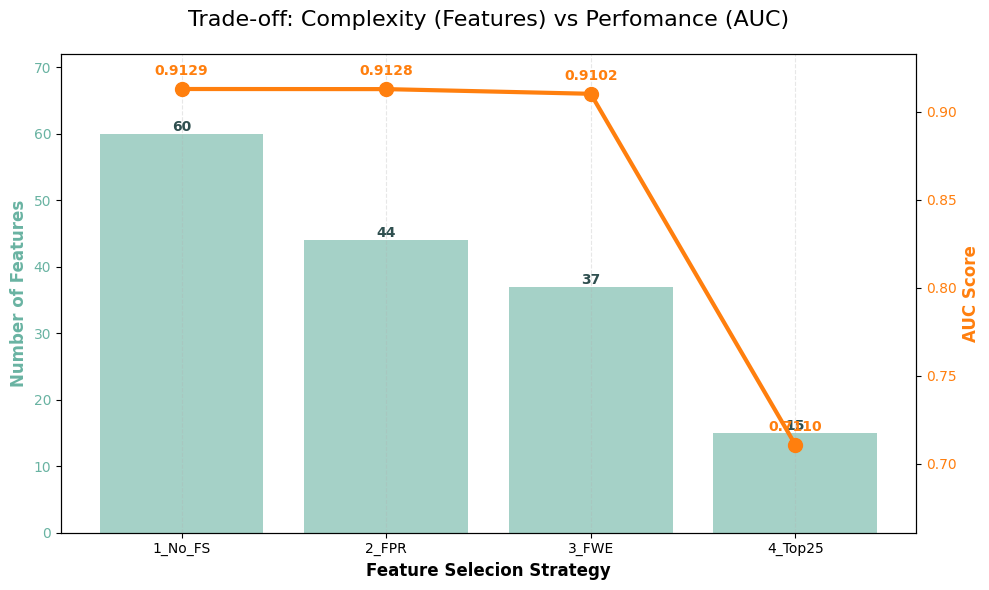

In [16]:
data = {
    'Strategy': ['1_No_FS', '2_FPR', '3_FWE', '4_Top25'],
    'AUC': [auc_1, auc_2, auc_3, auc_4],
    'Num_Features': [num_feats_1, num_feats_2, num_feats_3, num_feats_4]
}

df_res = pd.DataFrame(data)

fig, ax1 = plt.subplots(figsize=(10, 6))

color_bar = '#69b3a2'
color_line = '#ff7f0e'
bars = ax1.bar(df_res['Strategy'], df_res['Num_Features'], color=color_bar, alpha=0.6, label='Num Features')
ax1.set_xlabel('Feature Selecion Strategy', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Features', color=color_bar, fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor=color_bar)
ax1.set_ylim(0, max(df_res['Num_Features']) * 1.2)


for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', color='#2F4F4F', fontweight='bold')

ax2 = ax1.twinx()
ax2.plot(df_res['Strategy'], df_res['AUC'], color=color_line, marker='o', linewidth=3, markersize=10, label='AUC')
ax2.set_ylabel('AUC Score', color=color_line, fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor=color_line)


min_auc = min(df_res['AUC'])
ax2.set_ylim(min_auc - 0.05, max(df_res['AUC']) + 0.02)

for i, txt in enumerate(df_res['AUC']):
    ax2.annotate(f'{txt:.4f}', (i, df_res['AUC'][i]),
                 textcoords="offset points", xytext=(0,10), ha='center', color=color_line, fontweight='bold')


plt.title('Trade-off: Complexity (Features) vs Perfomance (AUC)', fontsize=16, pad=20)
ax1.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# **Model Selection**

The results demonstrate a clear trade-off between model complexity and predictive performance. While the baseline approach utilizing all 60 features achieved the highest AUC of 0.9129, the feature selection strategies revealed that a significant portion of the input variables provided redundant information. However, the aggressive Percentile strategy proved detrimental: by restricting the model to only 15 features (Top 25%), the AUC decreeased to 0.7110, indicating a critical loss of predictive signal.

Consequently, we select the **FWE (Family-Wise Error)** strategy as the optimal solution for this use case. Although it resulted in a negligible AUC decrease of approximately 0.002 compared to the baseline, it successfully reduced the feature space by over 38% (from 60 to 37 variables). This choice aligns with the principle of parsimony, as it serves a model that is computationally more efficient, less prone to overfitting, and easier to interpret, all while maintaining a predictive power almost identical to the full model.

Let's see the ROC for the FWE model:

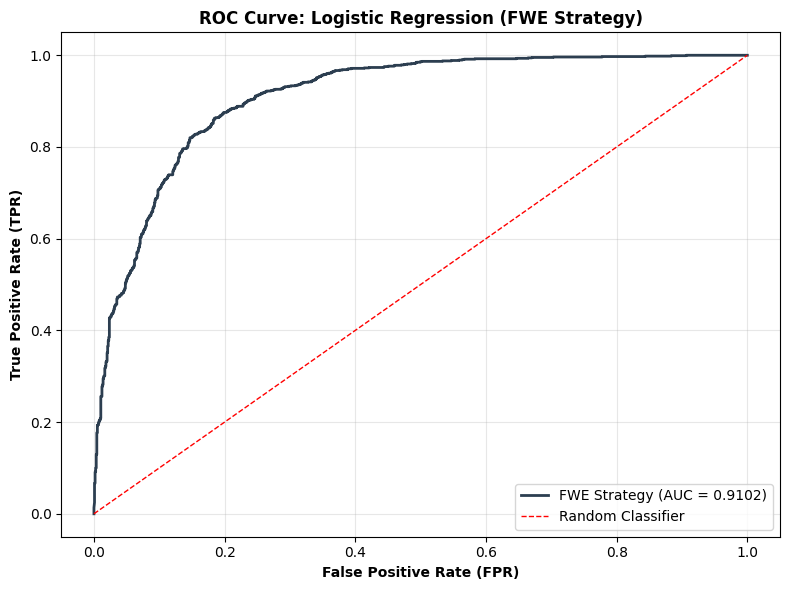

In [17]:
# ROC Curve for FWE Strategy

from sklearn.metrics import roc_curve, auc
from pyspark.sql.types import FloatType

# Extract probability of positive class and true label
extract_prob = F.udf(lambda v: float(v[1]), FloatType())
preds_pd = predictions_3.select(extract_prob('probability').alias('score'), 'label').toPandas()

# Compute ROC curve
fpr, tpr, _ = roc_curve(preds_pd['label'], preds_pd['score'])
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'FWE Strategy (AUC = {roc_auc:.4f})', color='#2c3e50', linewidth=2)
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier', linewidth=1)

plt.xlabel('False Positive Rate (FPR)', fontweight='bold')
plt.ylabel('True Positive Rate (TPR)', fontweight='bold')
plt.title('ROC Curve: Logistic Regression (FWE Strategy)', fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# **Feature Names Interpretation**

For this section we ceate two functions called `extract_feature_names_from_metadata` and `get_selected_names`.

`extract_feature_names_from_metadata` is just a helper functiion that we implement to get the metadata of the input schema column. As the `VectorAssembler` combines all the columns into a single vector, all the feature names are stored in the schema's metadat under the "ml_attr" key. In this function we go through the numeric, binary, and nominal attributes to reconstruct the full list of potential features in their correct order.

With `get_selected_names` we perform the mapping process. It accesses the feature selector stage within the trained pipeline (located at index -2) to retrieve the indices of the selected features. To ensure we have the correct metadata, we apply the preprocessing stages to a small sample of the data. Finally, we use the indices to filter the full list of names, thus returning only the specific variables that the FWE strategy select as significant.

In [18]:

def extract_feature_names_from_metadata(schema_col):
        feature_metadata = schema_col.metadata.get("ml_attr", {}).get("attrs")
        all_features = []
        if feature_metadata:
            for attr_type in ["numeric", "binary", "nominal"]:
                if attr_type in feature_metadata:
                    all_features.extend([attr["name"] for attr in feature_metadata[attr_type]])
        return all_features


def get_selected_names(pipeline_model, strategy_name, df_schema):

    selector_model = pipeline_model.stages[-2]
    selected_indices = selector_model.selectedFeatures

    prep_stages = pipeline_model.stages[:-2]

    temp_df = df_schema.limit(1)
    for stage in prep_stages:
        temp_df = stage.transform(temp_df)

    schema_col = temp_df.schema["features"]
    all_features = extract_feature_names_from_metadata(schema_col)

    if all_features:
        selected_names = [all_features[i] for i in selected_indices]
        return selected_names
    else:
        return ["Error: metadata could not be obtained"]

target_strategy = "3_FWE"
target_model = model_3


print("-" * 30)


selected_features = get_selected_names(target_model, target_strategy, train_df)

print(f"total selected variables: {len(selected_features)}")
print("-" * 30)

for i, name in enumerate(selected_features):
    print(f"{i+1}. {name}")

------------------------------
total selected variables: 37
------------------------------
1. job_ohe_self-employed
2. job_ohe___unknown
3. job_ohe_entrepreneur
4. poutcome_ohe_unknown
5. education_ohe___unknown
6. default_ohe_no
7. month_ohe___unknown
8. job_ohe_student
9. month_ohe_jan
10. loan_ohe_no
11. month_ohe_sep
12. loan_ohe___unknown
13. poutcome_ohe_success
14. month_ohe_jun
15. balance
16. job_ohe_housemaid
17. job_ohe_unknown
18. job_ohe_technician
19. contact_ohe___unknown
20. poutcome_ohe_failure
21. marital_ohe_single
22. marital_ohe_divorced
23. education_ohe_tertiary
24. month_ohe_nov
25. month_ohe_feb
26. poutcome_ohe___unknown
27. housing_ohe_no
28. month_ohe_may
29. marital_ohe___unknown
30. contact_ohe_telephone
31. job_ohe_management
32. job_ohe_blue-collar
33. poutcome_ohe_other
34. month_ohe_jul
35. default_ohe___unknown
36. education_ohe_primary
37. pdays


We observe that FWE strategy selects 37 features, thus discarding redundant information. The interpretation of these selected variables reveals four main insights for the model.

The first one is that the customer's financial health and lack of existing debt are very strong indicators of their capacity to open a term deposit. We extract this conclusion from the fact that the model selects variables such as `balance`, `housing_ohe_no`, and `loan_ohe_no`.

Second, we can see that the model also includes variables such as `poutcome_ohe_success` and `pdays`. This sugggest that the past behaviour of the customer provides a lot of predictive information since a customer who bought in the past is likely to buy again.

Furthermore, the model selects a many specific months, which suggests a strong seasonality in this dataset. This is probably due to some salary bonuses or fiscal periods.

Suprisingly, the model retains a lot of 'unknown' categories, which shows that the lack of information is itself a significant pattern. This could imply that a poor data quality leads to failed sales.

Finally, it is worth mentioning that most of the numerical variables are not kept by the model. This suggests that the categorical variables are more discriminative predictors than numerical variables like `age` or `duration`.

While `duration` is typically highly correlated with the target, relying on it is often considered 'data leakage' (since the `duration` is unknown before making the call). The fact that the FWE strategy removes it suggests that the selector successfully filters out variables that depend on the execution of the call itself.

Instead, the model prefers the profile of the client (their financial status, past history or specific job/education segments). As a result, we get a much more robust and realistic model for planning future marketing campaigns, as it relies on information available before picking up the phone.
